# 1.M3M图像预处理工作
> Reference Document:[Mavic_3M_Image_Processing_Guide_EN.pdf](https://dl.djicdn.com/downloads/DJI_Mavic_3_Enterprise/20230829/Mavic_3M_Image_Processing_Guide_EN.pdf)

1. 读取M3M图像的XMP信息,并保存目前必要的参数 **Dji_readXmp(im_DJI_path)**

2. 暗角补偿函数  **VignettingCorrect(im,XmpInfo)**

3. 畸变矫正函数  **distortionCorrect(im,XmpInfo)**

P.S.  暗角补偿、畸变矫正等函数都针对多光谱图像。可见光图像没有相关参数；

其次，按照参考文档中的叙述，对光谱图像的处理顺序为 **暗角补偿 -> 畸变矫正 -> 图像对齐**


In [29]:
import os
import cv2
import pyexiv2
import numpy as np 
from matplotlib import pyplot as plt
from easydict import EasyDict as edict


def show(im):
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)

    plt.imshow(im)



def Dji_readXmp(im_DJI_path):
    #---------------------------------#
    # obtain partial XMP information from NIR images
    # 1. for vignetting correction
    #   1.1 Calibrated Optical Center X 
    #   1.2 Calibrated Optical Center Y 
    #   1.3 Vignetting Data    -    [k0,k1,k2,k3,k4,k5]
    # 
    # 2. for distortion correction
    #   2.1 Dewarp Data
    #   2.2 Calibrated Hmatrix
    # 
    #  USELESS Param  
    # # 3. for image alignment
    # #   3.1 Dewarp Hmatrix
    #---------------------------------#
    XmpInfo  = edict()
    with pyexiv2.Image(im_DJI_path) as img:
        data  = img.read_xmp()
    
    try:
        XmpInfo.centerX = float(data['Xmp.drone-dji.CalibratedOpticalCenterX'])
    except:
        XmpInfo.centerX = None

    try:    
        XmpInfo.centerY = float(data['Xmp.drone-dji.CalibratedOpticalCenterY'])
    except:
        XmpInfo.centerY = None

    try:
        XmpInfo.vignetting_vector  = \
            [float(x) for x in data['Xmp.drone-dji.VignettingData'].split(',')]
    except:
        XmpInfo.vignetting_vector = None

    try:
        dewarp_data     =  [float(x) for x in data['Xmp.drone-dji.DewarpData'].split(';')[1].split(',')]
        XmpInfo.dewarp_data = edict(
            {
                'fx':dewarp_data[0],
                'fy':dewarp_data[1],
                'cx':dewarp_data[2],
                'cy':dewarp_data[3],
                'k1':dewarp_data[4],
                'k2':dewarp_data[5],
                'p1':dewarp_data[6],
                'p2':dewarp_data[7],
                'k3':dewarp_data[8],
            }
        )
    except:
        XmpInfo.dewarp_data = None

    try:
        XmpInfo.calibrated_Hmatrix = np.array([float(x) for x in data['Xmp.drone-dji.CalibratedHMatrix'].split(',')],dtype = np.float32).reshape(3,3)
    except:
        XmpInfo.calibrated_Hmatrix = None

    #---------------------------------#
    #  关于这个dewarp_Hmatrix矩阵的理解：
    #  参考文档说 是 将多光谱数据以及可见光数据 对齐到一个大疆自己涉及的平面中
    #  所以这个矩阵的意义是 多光谱数据 变换到 这个特殊平面
    #
    #  但是查看可见光图片的所有元数据，发现并没有对应的变换矩阵
    #  还没有找到其SDK中的相关实现函数
    #  所以这里先暂时 使用SIFT特征子来进行图像对齐，而非使用DJI设计的变换矩阵
    #---------------------------------#
    try:
        XmpInfo.dewarp_Hmatrix     = np.array([float(x) for x in data['Xmp.drone-dji.DewarpHMatrix'].split(',')],dtype = np.float32).reshape(3,3)
    except:
        XmpInfo.dewarp_Hmatrix = None

    try:
        XmpInfo.UTC_exposure       = data['Xmp.drone-dji.UTCAtExposure']
    except:
        XmpInfo.UTC_exposure       = None 

    return XmpInfo




def vignettingCorrect(im,XmpInfo):
    '''
    :Description:
    :Parameter  : im - data by opencv-python && im is not normalized
    :Return     : im_vegnetting  - image after vegnetting correction 
    '''
    # obtain information about Vignetting Correction from variable XmpInfo
    centerX = XmpInfo.centerX
    centerY = XmpInfo.centerY
    vignetting_vector = XmpInfo.vignetting_vector  # [k0,k1,k2,k3,k4,k5]

    # construct distance matrix 
    height,width,_ = im.shape
    x_matrix      = np.expand_dims(np.square(np.linspace(0,width-1,width,dtype=np.float32) - centerX),0).repeat(height,axis=0)
    y_matrix      = np.expand_dims(np.square(np.linspace(0,height-1,height,dtype=np.float32) - centerY),0).repeat(width,axis=0).T
    r_matrix      = np.sqrt(x_matrix + y_matrix)

    #---------------------------------#
    #  BUG: 未归一化的r矩阵会导致过渡矫正的情况
    #       即原本白色的区域 补偿后 变黑
    #  Solution:
    #       需利用最大距离来对r矩阵进行归一化，从而使得补偿的过程中更加平滑
    #---------------------------------#
    max_distance  = np.max(r_matrix).astype(np.float32)
    r_norm_matrix = r_matrix / max_distance
    weight_matrix = np.ones_like(r_matrix)         # shape - [height,width]
    for idx,k in enumerate(vignetting_vector):     # [k0 k1 k2 k3 k4 k5] 
        weight_matrix += np.power(r_norm_matrix,idx+1) * k
    weight_matrix = np.expand_dims(weight_matrix,axis=2).repeat(3,axis=2)

    im_normalize  = im.astype(np.float32) / 65535.0

    im_vegnetting = (im_normalize * weight_matrix) * 65535.0
    im_vegnetting = np.clip(im_vegnetting,0,65535)
    im_vegnetting = im_vegnetting.astype(np.uint8)
    
    return im_vegnetting

def distortionCorrect(im,XmpInfo):
    '''
    :Description:
    :Parameter  :
    :Return     :
    '''
    centerX = XmpInfo.centerX
    centerY = XmpInfo.centerY
    fx      = XmpInfo.dewarp_data.fx
    fy      = XmpInfo.dewarp_data.fy
    cx      = XmpInfo.dewarp_data.cx
    cy      = XmpInfo.dewarp_data.cy
    k1      = XmpInfo.dewarp_data.k1
    k2      = XmpInfo.dewarp_data.k2
    p1      = XmpInfo.dewarp_data.p1
    p2      = XmpInfo.dewarp_data.p2
    k3      = XmpInfo.dewarp_data.k3  
    
    camera_matrix = np.array([
        [fx,0,centerX+cx],
        [0,fy,centerY+cy],
        [0 ,0,1]
    ],dtype = np.float32)
    dist_coeffs  = np.array([k1,k2,p1,p2,k3],dtype= np.float32)

    #---------------------------------#
    # normalize image
    #---------------------------------#
    im_normalize = im.astype(np.float32) / 65535.0 
    
    im_norm_undist = cv2.undistort(im_normalize,camera_matrix,dist_coeffs,None)
    im_undist      = np.clip(im_norm_undist * 65535.0 , 0 ,65535) 
    im_undist      = im_undist.astype(np.uint8)

    return im_undist
    


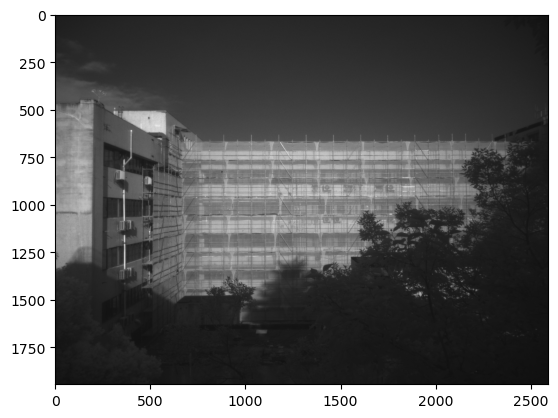

In [10]:
path_NIR = r'DateM3M\DJI_20240816170333_0001_MS_NIR.TIF'
im_NIR  = cv2.imread(path_NIR)
show(im_NIR)


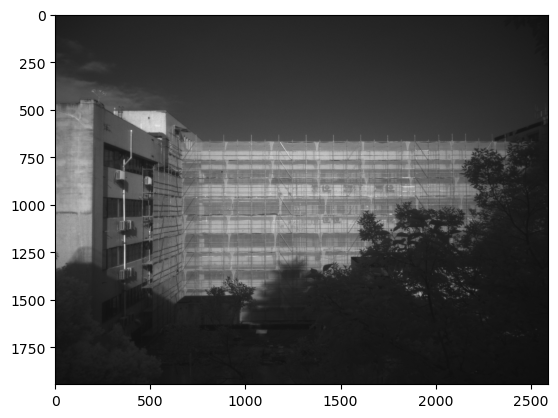

In [11]:
NIR_xmpInfo   = Dji_readXmp(path_NIR)
im_NIR_vegnet = vignettingCorrect(im_NIR,NIR_xmpInfo)
show(im_NIR_vegnet) 

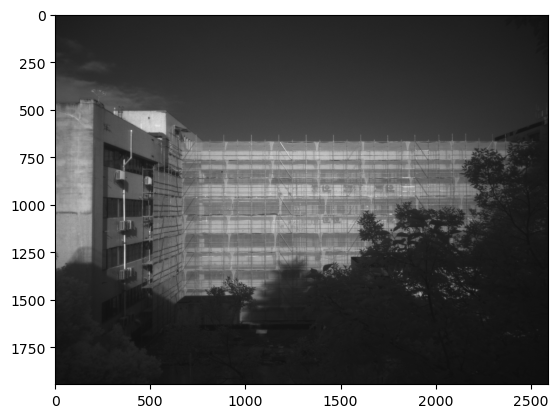

In [12]:
im_undist = distortionCorrect(im_NIR_vegnet,NIR_xmpInfo)
show(im_undist)

In [13]:
cv2.imwrite('NIR_vegnet.jpg',im_NIR_vegnet)
cv2.imwrite('NIR_undist.jpg',im_undist)

True

# 2. 图像对齐工作
> 根据以上所述，这里使用的是 SIFT特征子方式来进行图像对齐工作

In [34]:
import cv2
import numpy as np
import os


def getHomograpyMatrix(
        # rgb_im_path, nir_im_path, 
        rgb_im, nir_im, 
        save_path = None, method='SIFT'):
    """
    对齐红外图像到可见光图像,返回计算的单应矩阵
    """
    
    def detect_features(img, method='SIFT'):
        """
        检测图像中的特征点和描述子。
        """
        if method == 'SIFT':
            detector = cv2.SIFT_create()
        elif method == 'ORB':
            detector = cv2.ORB_create()
        else:
            raise ValueError("Unsupported method")
        
        keypoints, descriptors = detector.detectAndCompute(img, None)
        return keypoints, descriptors

    def match_features(descriptors1, descriptors2, ratio_test=0.7):

        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE,
                            trees=5)
        search_params = dict(check=50)
        
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        raw_matches = flann.knnMatch(descriptors1, descriptors2, k=2)
        matches = []

        for m, n in raw_matches:
            if m.distance < ratio_test * n.distance:
                matches.append(m)
        
        matches = sorted(matches, key=lambda x: x.distance)
        
        return matches

    def filter_matches_ransac(kp1, kp2, matches, reproj_thresh=5.0):
        """
        使用RANSAC算法过滤匹配，计算单应性矩阵。
        """
        if len(matches) < 4:
            raise ValueError("Not enough matches to compute homography.")
        
        # 提取匹配点的坐标
        pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
        pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])
        
        # 计算单应性矩阵和掩码
        H, status = cv2.findHomography(pts1, pts2, cv2.RANSAC, reproj_thresh)
        return H, status

    def draw_matches(img1, img2, kp1, kp2, matches):
        """
        绘制匹配的特征点，并标注其坐标
        """
        img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

        for match in matches:
            img1_idx = match.queryIdx
            img2_idx = match.trainIdx
            
            (x1, y1) = kp1[img1_idx].pt
            (x2, y2) = kp2[img2_idx].pt
            
            cv2.circle(img_matches, (int(x1), int(y1)), 5, (255, 0, 0), 2)
            cv2.putText(img_matches, f"({int(x1)}, {int(y1)})", (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
            
            cv2.circle(img_matches, (int(x2) + img1.shape[1], int(y2)), 5, (0, 255, 0), 2)
            cv2.putText(img_matches, f"({int(x2)}, {int(y2)})", (int(x2) + img1.shape[1], int(y2) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)

        return img_matches
    
     
    # rgb_im = cv2.imread(rgb_im_path)
    # nir_im = cv2.imread(nir_im_path)
    
    # 检测特征点和描述子
    kp1, des1 = detect_features(nir_im, method=method)
    kp2, des2 = detect_features(rgb_im, method=method)
    
    # 匹配特征点
    matches = match_features(des1, des2)
    
    # 使用RANSAC过滤误匹配并计算单应性矩阵
    H, status = filter_matches_ransac(kp1, kp2, matches)
    

    # 将计算的单应矩阵应用在近红外图像上，变换到可见光图片的平面上
    height, width, _ = rgb_im.shape
    aligned_nir_im = cv2.warpPerspective(nir_im, H, (width, height))
    blended_im = cv2.addWeighted(rgb_im, 0.3, aligned_nir_im, 0.7, 0)

    # 绘制匹配的特征点并标注坐标
    img_matches = draw_matches(nir_im, rgb_im, kp1, kp2, matches)

    # # 保存图像
    # cv2.imwrite(save_path + os.sep + os.path.basename(rgb_im_path), blended_im)
    # cv2.imwrite(save_path + os.sep + 'matches_' + os.path.basename(rgb_im_path), img_matches)

    # 返回单应矩阵
    return H,(blended_im,img_matches)



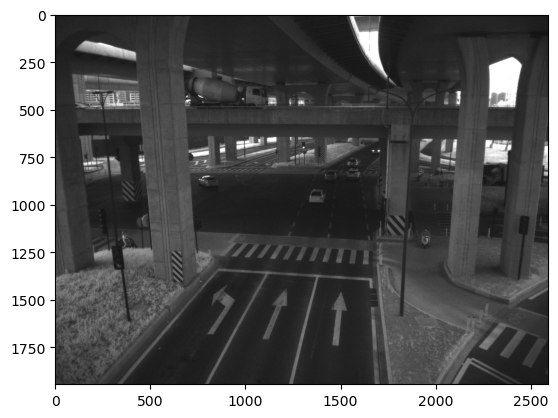

In [40]:
RGB_im_path = r'DateM3M/ImageSet/2024_0807_172315/RGB/0001.JPG'
NIR_im_path = r'DateM3M/ImageSet/2024_0807_172315/NIR/0001.TIF'

#---------------------------------#
#  对NIR图像进行暗角补偿 以及 畸变矫正
#---------------------------------#

NIR_im = cv2.imread(NIR_im_path)
RGB_im = cv2.imread(RGB_im_path)
show(NIR_im)


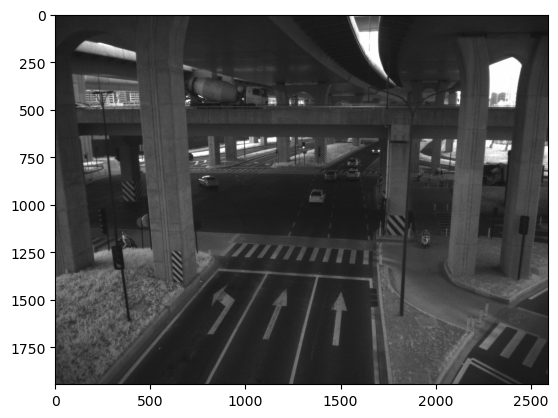

In [37]:
NIR_xmpInfo = Dji_readXmp(NIR_im_path)
NIR_im_vegnet = vignettingCorrect(NIR_im,NIR_xmpInfo)
show(NIR_im_vegnet)

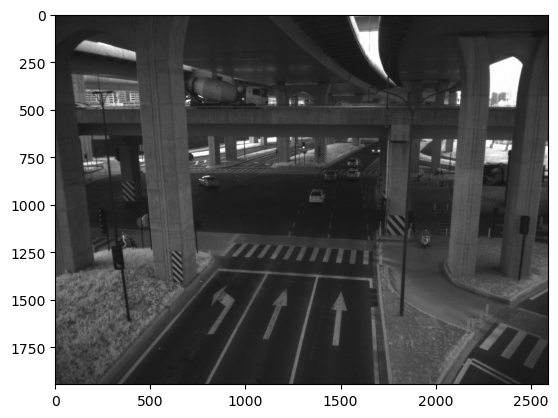

In [38]:
NIR_im_didest= distortionCorrect(NIR_im_vegnet,NIR_xmpInfo)
show(NIR_im_didest)

array([[ 1.70818573e+00,  1.66000509e-03,  4.60724899e+02],
       [ 1.76545529e-03,  1.71240509e+00,  2.70300661e+02],
       [-2.07307513e-06,  2.56977732e-06,  1.00000000e+00]])

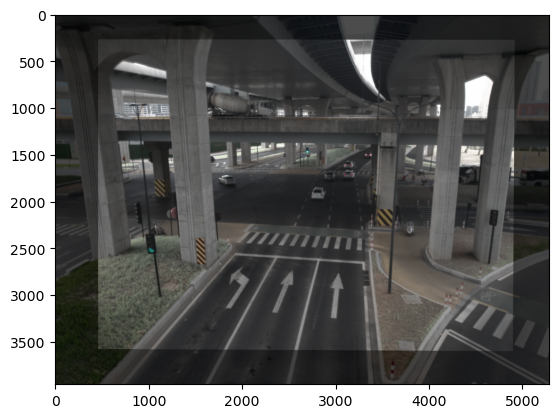

In [44]:
H,(blend_im,match_im) = getHomograpyMatrix(RGB_im,NIR_im_didest,'.')
show(blend_im)
H

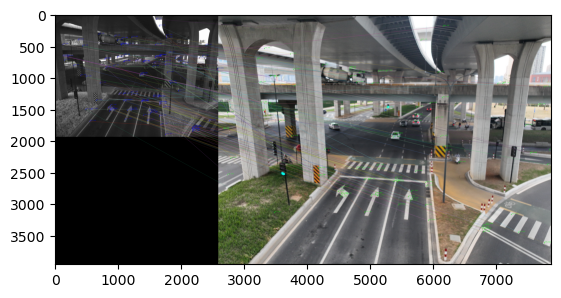

In [45]:
show(match_im)

# 3.计算两张图片的时间差
> 图片拍摄的瞬间的时间差

In [26]:
from datetime import datetime

RGB_im_path = r'DateM3M/ImageSet/2024_0807_172315/RGB/0001.JPG'
NIR_im_path = r'DateM3M/ImageSet/2024_0807_172315/NIR/0001.TIF'


RGB_xmpInfo = Dji_readXmp(RGB_im_path)
NIR_xmpInfo = Dji_readXmp(NIR_im_path)

datetime_RGB = RGB_xmpInfo['UTC_exposure']
datetime_NIR = NIR_xmpInfo['UTC_exposure']


# 将字符串转换为datetime对象
datetime_RGB = datetime.fromisoformat(datetime_RGB)
datetime_NIR = datetime.fromisoformat(datetime_NIR)

# 计算时间差
time_difference = datetime_RGB - datetime_NIR

# 输出时间差
print("Time difference:", time_difference.total_seconds() * 1000 ,'ms')


Time difference: -26.52 ms
